# Step 3 Calculating interaction of randomly generated particles in 3D space

In [1]:
import numpy as np
from scipy.special import lpmn, factorial
from multipole_test import Vlm
from multipole_test import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

In [5]:
#case 3.1 construction: random particles
num_particles = 5000
x_i = np.ndarray(shape=(3, num_particles))
x_i[0] = 20 * np.random.rand(num_particles) - 10
x_i[1] = 20 * np.random.rand(num_particles) - 10
x_i[2] = 20 * np.random.rand(num_particles) - 10
x_i = np.transpose(x_i)
q = np.ones(num_particles)

In [4]:
#case 3.2 construction: nearly uniform distributed particles:
num_particles_in_a_box = 1
num_particels_1D = 3
num_particles = num_particles_in_a_box * num_particels_1D **3
X = np.zeros(shape=(num_particles,3))

for i in range(0,num_particels_1D):
    for j in range(0,num_particels_1D):
        for k in range(0,num_particels_1D):
            X[i*num_particels_1D*num_particels_1D+j*num_particels_1D+k] = [i,j,k] 

q = np.ones(num_particles)

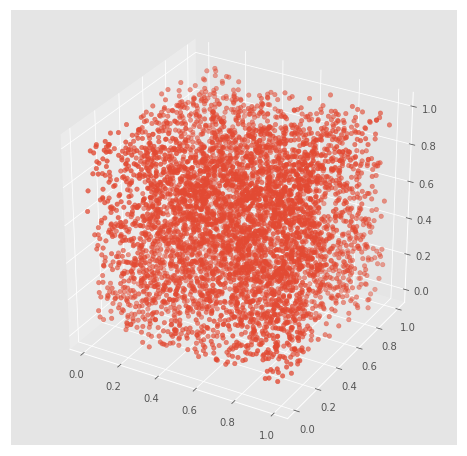

In [7]:
plot_3d(x0_i)

In [6]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

import timeit

start = timeit.default_timer()

[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

stop = timeit.default_timer()

print(stop - start) 

In [8]:
# analytical answer
pair_potential = np.zeros(shape=(num_particles,num_particles)) 
for i in range(0, num_particles):
    for j in range(i+1, num_particles):
        pair_potential[i][j] = 1 / (op.distance_cal(x0_i[i], x0_i[j]) * scale_factor[1])
        
pair_potential

array([[0.        , 0.06812863, 0.15820869, ..., 0.05649841, 0.12099448,
        0.06329938],
       [0.        , 0.        , 0.09689746, ..., 0.05694682, 0.08658592,
        0.10946037],
       [0.        , 0.        , 0.        , ..., 0.07999991, 0.13680292,
        0.08175991],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.05927534,
        0.05568365],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12086302],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
J_analytic = np.zeros(num_particles)
for i in range(0, num_particles):
    for j in range(0, num_particles):
        if j<i:
            J_analytic[i] += pair_potential[j][i]
        if j>i:
            J_analytic[i] += pair_potential[i][j]

J_analytic

array([504.59831631, 452.56021964, 584.96029377, ..., 445.74118797,
       547.02654483, 464.14947106])

In [10]:
total_energy = 0.5 * sum(J_analytic)
total_energy

1177963.034128455

In [11]:
from multipole_test import fmm_level as fl
from multipole_test import fmm_q_source as fq

In [12]:
# build list of q_source
q_source = np.ndarray(shape=(len(x0_i)), dtype=fq) 
for i in range(0, len(x0_i)):
    q_source[i] = fq(x0_i[i], q[i])
    

In [13]:
# run the calculation:
#1 construction of boxes at each level with Olm
btm_level = 3
p = 5
ws_index = 4
f_btm_level = fl(btm_level, q_source, p, ws_index)

f_top_level = f_btm_level
while (f_top_level.level != 1):
    print(f_top_level.level)
    f_top_level = f_top_level.lower_level_construction()
    
#2 calculation the interaction and translation the potential
print('----------')
f_level_i = f_top_level
while (f_level_i.level != f_btm_level.level):
    f_level_i.Mlm_translation_to_higher_level()
    f_level_i = f_level_i.higher_level
    print(f_level_i.level)
    f_level_i.box_interactions()
    
f_level_i.level

3
2
----------
2
3


3

In [14]:
#3 calculation of J far field
J_far_field = np.zeros(num_particles)
for i in range(0, num_particles):
    if not f_btm_level.box_list[q_source[i].box_id].Mlm:
        J_far_field[i] = 0.
    else:
        J_far_field[i] = f_btm_level.box_list[q_source[i].box_id].Mlm.product(q_source[i].Olm).sum().real 

J_far_field /= scale_factor[1]

In [15]:
J_far_field

array([ 806.77252742, 2064.81509951,    0.        , ...,  177.27724707,
         77.97233047,  164.99157228])

In [16]:
#4 calculation of J near filed
J_near_field = np.zeros(num_particles)
for i in range(0,num_particles):
    J_near_field[i] = 0.
    for j in f_btm_level.box_list[q_source[i].box_id].q_source_id_set:
        if j == i:
            continue
        J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])
    for NN_box_id in f_btm_level.box_list[q_source[i].box_id].NN_box_id_set:
        for j in f_btm_level.box_list[NN_box_id].q_source_id_set:
            J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])

In [17]:
J_near_field

array([394.28560532, 295.25536683, 584.96029377, ..., 274.48647782,
       467.09040299, 316.89999076])

In [18]:
J_total = J_far_field + J_near_field
J_total

array([1201.05813274, 2360.07046633,  584.96029377, ...,  451.76372489,
        545.06273346,  481.89156304])

In [19]:
total_energy = 0.5 * sum(J_total)
total_energy

1497591.515169179

In [20]:
J_error = np.abs(J_total-J_analytic) / J_analytic
J_error

array([1.38022620e+00, 4.21493133e+00, 2.72089532e-15, ...,
       1.35112865e-02, 3.58997455e-03, 3.82249536e-02])

In [31]:
J_error[1:50]

array([4.21493133e+00, 2.72089532e-15, 2.13746108e+00, 9.66019306e-01,
       1.81673659e+00, 2.28038842e+00, 2.93634393e+00, 1.76530686e+00,
       4.26635475e+00, 1.45338996e+00, 2.58182991e+00, 3.14634301e+00,
       2.72892125e+00, 4.49743362e+00, 2.46282808e+00, 6.73978372e+00,
       5.16942210e+00, 5.75538888e+00, 5.19752155e+00, 2.34295228e+00,
       2.74115654e+00, 6.92252478e+00, 2.88230267e+00, 3.39904621e+00,
       3.33959010e+00, 1.24880290e+00, 2.03569102e+00, 2.99310933e+00,
       4.18621384e+00, 3.85145080e+00, 1.65642418e+00, 1.96452057e-15,
       4.71666754e+00, 3.40009815e+00, 2.34177037e+00, 4.22090886e+00,
       2.21431357e+00, 3.17009641e+00, 4.15146377e+00, 4.83298630e+00,
       6.19372717e+00, 3.78334151e+00, 3.48836135e+00, 2.39167876e+00,
       4.42629175e+00, 1.96976869e+00, 4.16219589e+00, 1.29338296e+00,
       3.47734642e-15])

In [32]:
x0_i[1:50]

array([[0.21182062, 0.93776032, 0.42235108],
       [0.57825706, 0.57438894, 0.42687755],
       [0.42576326, 0.23948393, 0.74965257],
       [0.60382367, 0.3626129 , 0.42498634],
       [0.14103975, 0.39221832, 0.50218513],
       [0.30715884, 0.22523857, 0.13375213],
       [0.56771195, 0.39088032, 0.97459573],
       [0.27218537, 0.39433017, 0.16409788],
       [0.0334893 , 0.41321821, 0.09896451],
       [0.76288185, 0.60006039, 0.13532259],
       [0.71225948, 0.69036826, 0.69763498],
       [0.67533448, 0.95466302, 0.55888725],
       [0.13784336, 0.49803233, 0.30932867],
       [0.92569867, 0.30152316, 0.67038027],
       [0.94708895, 0.37565799, 0.10537863],
       [0.02244838, 0.6273885 , 0.00600345],
       [0.57853185, 0.86349635, 0.81481735],
       [0.02350851, 0.45057445, 0.9571924 ],
       [0.93938245, 0.91477735, 0.9528373 ],
       [0.49941584, 0.22110552, 0.2293825 ],
       [0.92165561, 0.06341331, 0.66628585],
       [0.98796387, 0.16431171, 0.81648512],
       [0.

In [ ]:
J_error = np.abs(J_total-J_analytic) / J_analytic
J_error

In [ ]:
for i in range(0,len(f_btm_level.box_list)):
    if f_btm_level.box_list[i]:
        print(i)

In [ ]:
index1 = 27
index2 = 465


Y = np.ndarray(shape=(4,3)) #Cartesian coordiantes of box centers
Y[0] = f_btm_level.box_list[index1].x
Y[1] = f_btm_level.box_list[index2].x
Y[2] = f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index1)].x
Y[3] = f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index2)].x

y_i = np.ndarray(shape=(2,3))
y_i[0] = q_source[0].x
y_i[1] = q_source[1].x


In [ ]:
Y

In [ ]:
analytic_potential = 0 
for i in range(0, len(y_i)):
    for j in range(i+1, len(y_i)):
        analytic_potential += 1 / op.distance_cal(y_i[i], y_i[j])

analytic_potential / scale_factor[1]

In [ ]:
# test on conversion operation
p1 = 5

r1_1 = op.cartesian_to_spherical(y_i[0] - Y[0])
Olm_q1_x1_k = op.O_expansion(p1, r1_1)

Olm_q1_x1_k.Vp

In [ ]:
q_source[0].Olm.Vp

In [ ]:
Y31 = Y[0] - Y[2]
Olm_q1_x3_k = op.O_to_O(Olm_q1_x1_k, Y31)

Olm_q1_x3_k.Vp

In [ ]:
f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index1)].Olm.Vp

In [ ]:
Y34 = Y[3] - Y[2]
Mlm_q1_x4_k = op.O_to_M(Olm_q1_x3_k, Y34)
Mlm_q1_x4_k.Vp

In [ ]:
f_btm_level.lower_level.box_list[f_btm_level.box_id_to_lower_level(index2)].Mlm.Vp

In [ ]:
Y42 = Y[1] - Y[3]
Mlm_q1_x2_k = op.M_to_M(Mlm_q1_x4_k, Y42)

Mlm_q1_x2_k.Vp

In [ ]:
f_btm_level.box_list[index2].Mlm.Vp